In [1]:
from synth_text.text_utils import RenderFont
from synth_text.colorize3_poisson import Colorize

import scipy.misc
import numpy as np
import matplotlib.pyplot as plt
import random
import h5py
import cv2

In [246]:
db = h5py.File('/media/nina/Seagate Backup Plus Drive/hockey/blobs_data/part_40000_110000_not_number.h5')
img_names = db['image'].keys()
random.shuffle(img_names)
img_names = list(img_names)
img_player = db['image'][img_names[0]].value
mask_player = db['mask'][img_names[0]].value
db.close()

In [159]:
text_renderer = RenderFont('synth_text/data')
colorizer = Colorize('synth_text/data')

def render_text():
    collision_mask = np.zeros((120, 120), dtype=np.uint8)#text_renderer.max_font_h *3, text_renderer.max_font_h * 4 ), dtype=np.uint)
    font = text_renderer.font_state.sample()
    font = text_renderer.font_state.init_font(font)
    render_res = text_renderer.render_sample(font,collision_mask)
    text_mask,loc,bb,text = render_res
    return text_mask, text

In [259]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data
from scipy.misc import imresize

def sin_transform(image, n=10, x=0):
    rows, cols = image.shape[0], image.shape[1]
    image = image.astype(np.float)

    rows, cols = image.shape[0], image.shape[1]

    src_cols = np.linspace(0, cols, 20)
    src_rows = np.linspace(0, rows, 10)
    src_rows, src_cols = np.meshgrid(src_rows, src_cols)
    src = np.dstack([src_cols.flat, src_rows.flat])[0]

    # add sinusoidal oscillation to row coordinates
    dst_rows = src[:, 1] - np.sin(np.linspace(x, 2 * np.pi+x, src.shape[0])) * n
    
    dst_cols = src[:, 0]
    dst_rows *= 1.5
    dst_rows -= 1.5 * n
    dst = np.vstack([dst_cols, dst_rows]).T


    tform = PiecewiseAffineTransform()
    tform.estimate(src, dst)

    #out_rows = image.shape[0] - 1.5 * 50
    #out_cols = cols
    out = warp(image, tform)#, output_shape=(out_rows, out_cols))
    out = imresize(out, image.shape)
    out = out.astype(np.uint8)

    return out

def get_orient_player(mask):
    cnt, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = np.concatenate(cnt, axis=0)
    ellipse = cv2.fitEllipse(cnt)
    center, size, angle = ellipse
      
    angle = (angle + 90) % 180 - 90
    #if angle > 90:
    #    angle = angle - 180
        
    return center, size, angle


def get_orient_text(mask, text):
    cnt, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = np.concatenate(cnt, axis=0)
    ellipse = cv2.fitEllipse(cnt)
    center, size, angle = ellipse
      
    angle = (angle + 90) % 180 - 90
    
    #stable orientation text
    if len(text) > 1 and size[0] < size[1] and abs(angle) > 45:
        angle = angle - 90 if angle > 0 else angle + 90
        size = (size[1], size[0])
  
    return center, size, angle

def crop(mask):
    cnt, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = np.concatenate(cnt, axis=0)
    x, y, w, h = cv2.boundingRect(cnt)
    return mask[y:y+h, x:x+w]

def add_pad(mask, pad=1.0):
    h, w = mask.shape
    pad_h, pad_w = int(pad * h), int(pad * w)
    pad_mask = np.zeros((h + 2 * pad_h, w + 2 * pad_w), dtype=np.uint8)
    pad_mask[pad_h:pad_h+h, pad_w:pad_w+w] = mask
    return pad_mask

def correct_orient(mask, angle, scale):
    h, w = mask.shape
    rot_matrix = cv2.getRotationMatrix2D((h/2, w/2), angle, scale)
    return cv2.warpAffine(mask, rot_matrix, (w, h))#, (cols, rows))

25


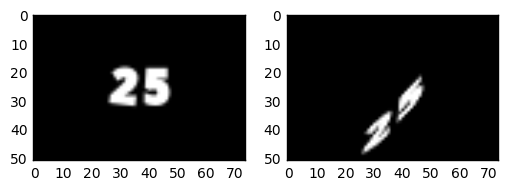

In [77]:
#def place_number(img_player=None, mask_player=None):

#render txt
img_text, text = NumberRender().sample_text()#render_text()


#transform text
img_text = crop(img_text)
img_text = add_pad(img_text, pad=1.2)
plt.subplot(1, 2, 1), plt.imshow(img_text, cmap='gray')
#plt.subplot(1, 3, 2), plt.imshow(img_text)
img_text = sin_transform(img_text, n=random.randint(10, 15), x=random.randint(1, 10))
plt.subplot(1, 2, 2), plt.imshow(img_text,  cmap='gray')
"""
#correct orientation
n_cntr, n_sz, n_ang = get_orient_text(img_text, text)
p_cntr, p_sz, p_ang = get_orient_player(mask_player)

img_text = crop(img_text)
img_text = add_pad(img_text, pad=1)
cor_angle = -(p_ang - n_ang)
cor_scale = p_sz[1] / n_sz[1] * 0.25
img_text = correct_orient(img_text, cor_angle, cor_scale)
plt.subplot(1, 3, 3), plt.imshow(img_text)
"""
plt.show()




In [444]:
class NumberRender:
    def __init__(self, data_dir='synth_text/data'):
        self.text_renderer = RenderFont(data_dir)
        self.colorizer = Colorize(data_dir)
        
        self._alpha_number = 0.6
        self._min_shift = 0.10
        self._max_shift = 0.25
        self._min_scale = 0.8
        self._max_scale = 1
        self._color_h = 3
        self._max_attempt = 10
        
    def sample_text(self):
        collision_mask = np.zeros((70, 70), dtype=np.uint8)#text_renderer.max_font_h *3, text_renderer.max_font_h * 4 ), dtype=np.uint)
        font = self.text_renderer.font_state.sample()
        font = self.text_renderer.font_state.init_font(font)
        render_res = self.text_renderer.render_sample(font,collision_mask)
        if render_res:
            text_mask,loc,bb,text = render_res
            return text_mask, text
        else:
            return None
        
    def sample_transform(self, mask):
        mask = crop(mask)
        mask = add_pad(mask, pad=1.2)
        mask = sin_transform(mask, n=random.randint(10, 15), x=random.randint(1, 10))
        return mask
    
    def sample_shift(self):
        return self._min_shift + (self._max_shift - self._min_shift) * random.random() 
    
    def sample_scale(self):
        return self._min_scale + (self._max_scale - self._min_scale) * random.random() 
    
    def colorize(self, rgb, text_mask):
        return self.colorizer.color(rgb,[text_mask],np.array([self._color_h]))
    
    def correct_orient(self, img_text, text, mask_player):
        n_cntr, n_sz, n_ang = get_orient_text(img_text, text)
        p_cntr, p_sz, p_ang = get_orient_player(mask_player)

        img_text = crop(img_text)
        img_text = add_pad(img_text, pad=2)
        
        cor_angle = -(p_ang - n_ang)
        #cor_scale = p_sz[0] / n_sz[0] * self._scale_number
        img_text = correct_orient(img_text, cor_angle, 1)#cor_scale)
        return img_text
    
    def check_mask(self, text, mask):
        text = np.array(text, dtype=np.bool)
        mask = np.array(mask, dtype=np.bool)
        text_in = np.logical_and(text, mask)
        return not(np.logical_xor(text, text_in).sum())
    
    def place_text(self, text_mask, img_player, mask_player):

        text_mask = crop(text_mask)
        text_mask = add_pad(text_mask, pad=0.1)
        p_cntr, p_sz, p_ang = get_orient_player(mask_player)
        n_cntr, n_sz, n_ang = get_orient_text(img_text, text)
        
        for i in range(self._max_attempt):
            alpha = min(p_sz) / max(n_sz) * self.sample_scale()
            h, w = map(lambda x: int(x * alpha), text_mask.shape)
            sample_text = scipy.misc.imresize(text_mask, (h, w))
            sample_text = add_pad(text_mask, pad=0.07)
            
            alpha_shift = self.sample_shift()
            p_h = p_sz[1]
            pcntr_x, pcntr_y = p_cntr[0], p_cntr[1]
            pcntr_x = pcntr_x - p_h * alpha_shift * sin(radians(-p_ang))
            pcntr_y = pcntr_y - p_h * alpha_shift * cos(radians(-p_ang))

            h, w = sample_text.shape
            tcntr_x, tcntr_y = (w // 2, h // 2)
            x = int(pcntr_x - tcntr_x)
            y = int(pcntr_y - tcntr_y)
            p_h, p_w = mask_player.shape
            
            if not(x > 0 and y > 0 and x + w < p_w and y + h < p_h):
                continue
                
            if  self.check_mask(sample_text, mask_player[y:y+h, x:x+w]):
                res_img = img_player.copy()
                res_crop = renderer.colorize(res_img[y:y+h, x:x+w], sample_text)
                res_img[y:y+h, x:x+w] = res_crop
                return res_img
            
        return None
            
    def render_text(self, simg_player, mask_player):
        res = self.sample_text()
        if res is None:
            return None
        text_mask, text = res
        
        text_mask = self.sample_transform(text_mask)

        # TODO, don't work!
        #text_mask = self.correct_orient(text_mask, text, mask_player)
        res_img = self.place_text(text_mask, img_player, mask_player)
        if res_img:
            return res_img, text

        return None


In [286]:
db = h5py.File('/media/nina/Seagate Backup Plus Drive/hockey/blobs_data/part_40000_110000_not_number.h5')
img_names = db['image'].keys()
random.shuffle(img_names)
img_names = list(img_names)

56


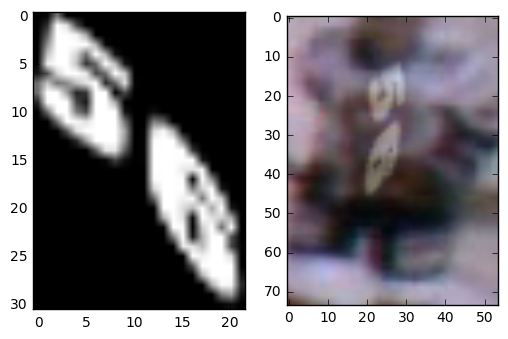

In [453]:
i = random.randint(0, len(img_names))
img_player = db['image'][img_names[i]].value

mask_player = db['mask'][img_names[i]].value

renderer = NumberRender()
in_txt, x_txt = renderer.render_text(img_player.copy(), mask_player.copy())

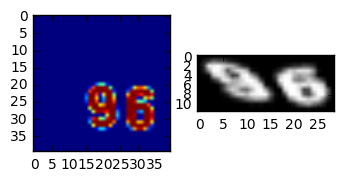

In [248]:
text_mask = crop(in_txt.copy())
plt.imshow(text_mask, cmap='gray'), plt.show()
text_mask = crop(text_mask)
text_mask = add_pad(text_mask, pad=0.1)
p_cntr, p_sz, p_ang = get_orient_player(mask_player)
n_cntr, n_sz, n_ang = get_orient_text(img_text, text)
        

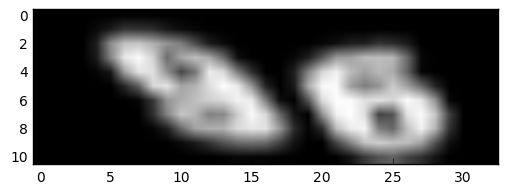

(<matplotlib.image.AxesImage at 0x7f2eebe34e50>, None)

In [249]:
alpha = min(p_sz) / max(n_sz) * 0.6
h, w = map(lambda x: int(x * alpha), text_mask.shape)
text_mask = scipy.misc.imresize(text_mask, (h, w))
text_mask = add_pad(text_mask, pad=0.07)
plt.imshow(text_mask, cmap='gray'), plt.show()


In [250]:
from math import sin, cos, radians

alpha_shift = 0.10
p_h = p_sz[1]
pcntr_x, pcntr_y = p_cntr[0], p_cntr[1]
pcntr_x = pcntr_x - p_h * alpha_shift * sin(radians(-p_ang))
pcntr_y = pcntr_y - p_h * alpha_shift * cos(radians(-p_ang))

h, w = text_mask.shape
tcntr_x, tcntr_y = (w // 2, h // 2)
x = int(pcntr_x - tcntr_x)
y = int(pcntr_y - tcntr_y)
print(x, y)

(14, 36)


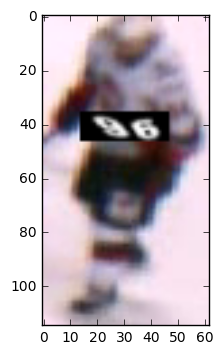

(<matplotlib.image.AxesImage at 0x7f2eebd72750>, None)

In [251]:
text_img = np.dstack((text_mask, text_mask, text_mask))
new_player = img_player.copy()
new_player[y:y+h, x:x+w] = text_img
plt.imshow(new_player), plt.show()

In [252]:
new_player = img_player.copy()
c_crop = renderer.colorize(new_player[y:y+h, x:x+w], np.array(text_mask, dtype=np.uint8))

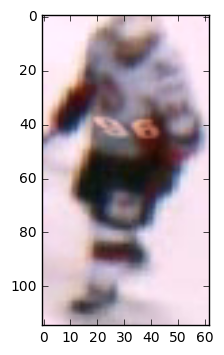

(<matplotlib.image.AxesImage at 0x7f2eebca38d0>, None)

In [253]:
new_player[y:y+h, x:x+w] = c_crop
plt.imshow(new_player), plt.show()

/home/nina/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


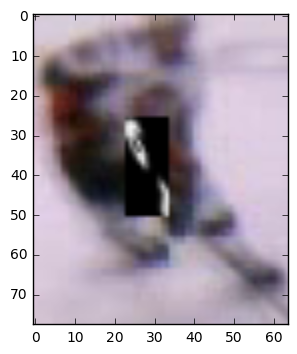

(<matplotlib.image.AxesImage at 0x7f2f049c7950>, None)

In [177]:
text_img = np.dstack((text_mask, text_mask, text_mask))
new_player = img_player.copy()
new_player[y:y+h, x:x+w] = text_img
plt.imshow(new_player), plt.show()

In [181]:
p_ang, s

-23.842636108398438

In [ ]:
print(n_sz)
        alpha = p_sz[0] / n_sz[0] * self._alpha_number
        n_sz = map(lambda x: int(x * alpha), n_sz)
        print(n_sz)
        text_mask = scipy.misc.imresize(text_mask, n_sz)
        
        text_mask = add_pad(text_mask, 0.2)
        
        for scale in [1, 0.95, 0.9, 0.8]:
            #scaling
            sz = text_mask.shape
            sz = map(lambda x: int(x * scale), sz)
            sample_text = scipy.misc.imresize(text_mask, sz)
            
            #compute rect number in player
            pcntr_x, pcntr_y = p_cntr[0] ,p_cntr[1]
            tcntr_x, tcntr_y = (sz[1] // 2, sz[0] // 2)
            tw, th = sz[1], sz[0]
            x = pcntr_x - tcntr_x
            y = pcntr_y - tcntr_y
            print(sz, p_cntr)
            print(x, y)
            break

In [152]:
x = crop(x)


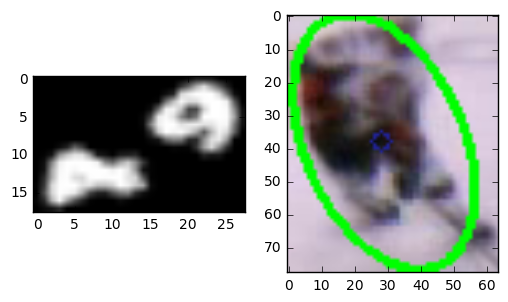

In [153]:
img = img_player.copy()
mask = mask_player.copy()
img2 = x.copy()
img2 = np.dstack((x, x, x))
cv2.circle(img, (28, 38), 3, color=(32, 34, 152))
ellipse = get_orient_player(mask)
ellipse2 = get_orient_text(x, x_txt)
cv2.ellipse(img,ellipse,(0,255,0),2)
#cv2.ellipse(img2, ellipse2,(0,255,0),2)

plt.subplot(1, 2, 1), plt.imshow(img2)
plt.subplot(1, 2, 2), plt.imshow(img)
plt.show()


In [1]:
import random
import h5py
from synth_utils import NumberRender
import matplotlib.pyplot as plt
import cv2

In [2]:
def post_process(img, max_pad=5, max_sigma=1.1, max_kernel=7):
    pad_x1 = random.randint(0, max_pad + 1)
    pad_x2 = random.randint(0, max_pad + 1)
    pad_y1 = random.randint(0, max_pad + 1)
    pad_y2 = random.randint(0, max_pad + 1)
    kernel = random.choice(range(3, max_kernel, 2))
    sigma = max_sigma * random.random()
    
    h, w, c = img.shape
    img = img[pad_y1:h-pad_y2, pad_x1:w-pad_x2]
    img = cv2.GaussianBlur(img, (kernel, kernel), sigma)
    return img

In [3]:
db = h5py.File('/media/nina/Seagate Backup Plus Drive/hockey/blobs_data/part_40000_110000_not_number.h5')
img_names = db['image'].keys()
random.shuffle(img_names)
img_names = list(img_names)

synth_text/text_utils.py:452: RuntimeWarning: divide by zero encountered in true_divide
  r = np.abs(sizes[:,1]/sizes[:,0]) # width/height


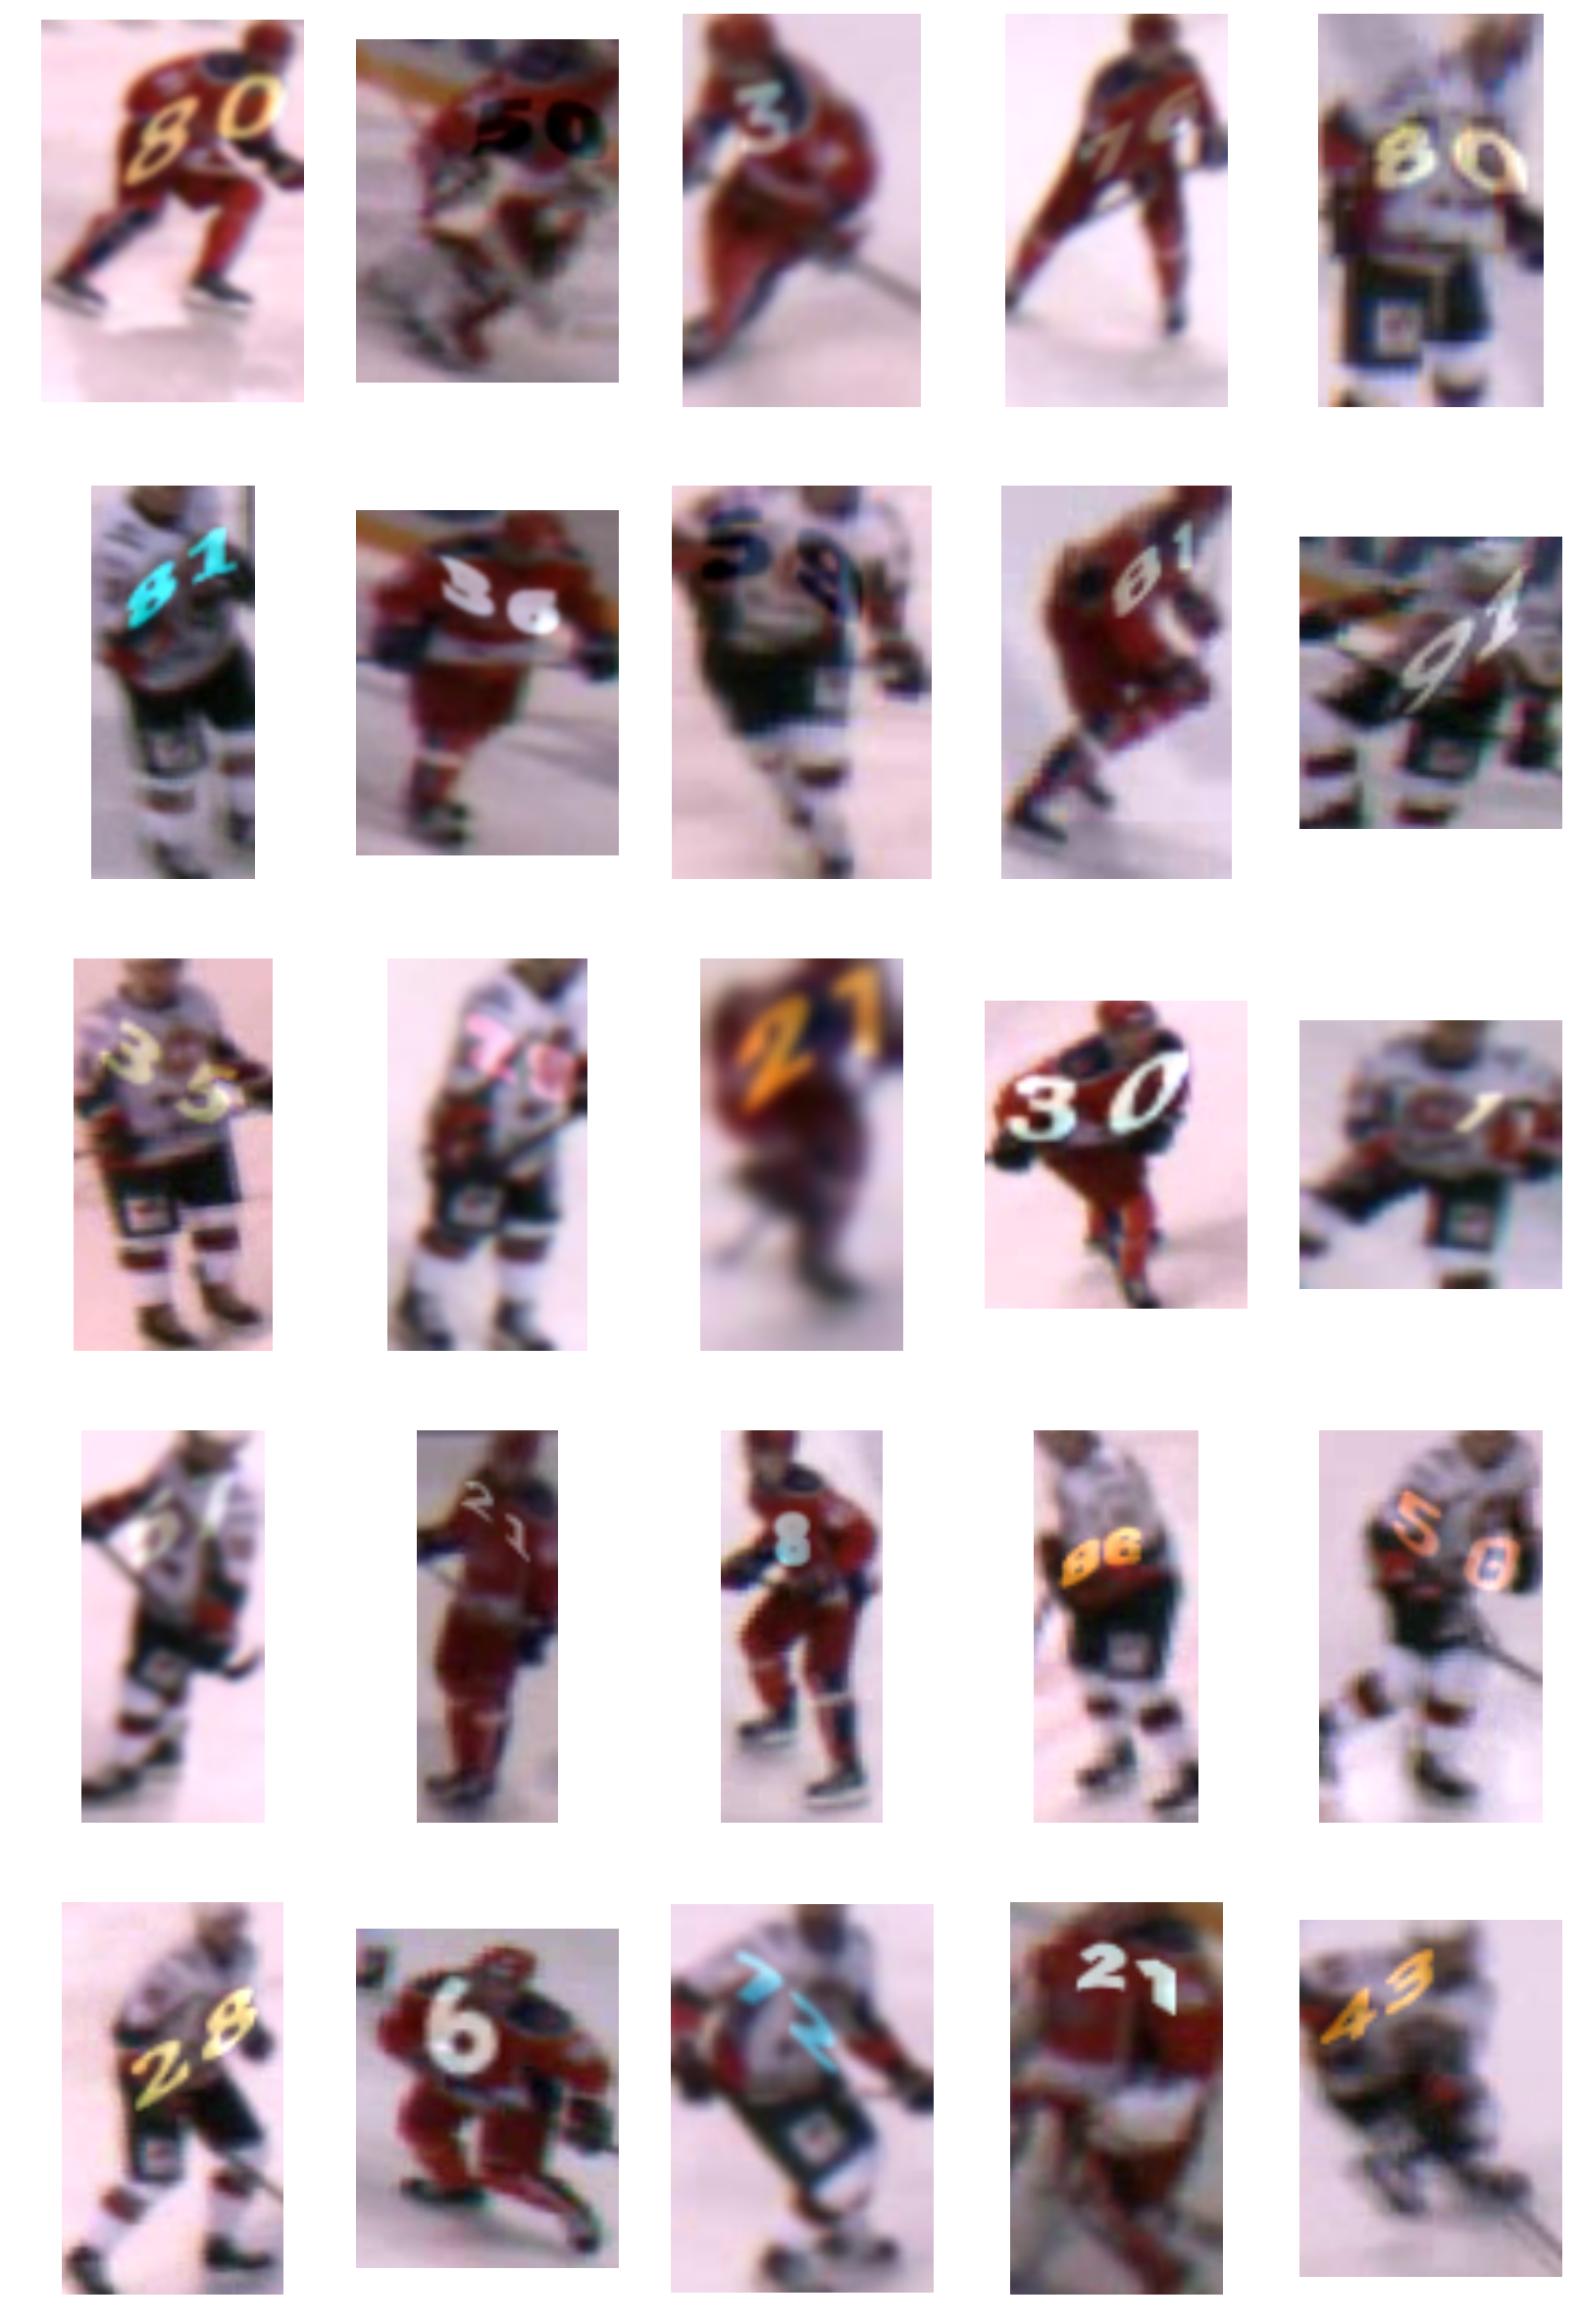

In [4]:
N = 5
plt.figure(figsize=(20, 30))

j = 0
while True:
    if j >= N * N:
        break
        
    i = random.randint(0, len(img_names) - 1)
    img_player = db['image'][img_names[i]].value
    mask_player = db['mask'][img_names[i]].value

    renderer = NumberRender()
    res = renderer.render_text(img_player.copy(), mask_player.copy())
    if res is not None:
        plt.subplot(N, N, j + 1), plt.axis('off')
        plt.imshow(res['img'])  
        j += 1
        
plt.show()

In [6]:
res

{'h': 38, 'img': array([[[203, 171, 187],
         [195, 165, 180],
         [192, 162, 177],
         ..., 
         [202, 175, 187],
         [202, 175, 187],
         [203, 176, 188]],
 
        [[208, 176, 192],
         [200, 170, 185],
         [195, 165, 180],
         ..., 
         [203, 176, 188],
         [203, 176, 188],
         [204, 177, 189]],
 
        [[228, 189, 203],
         [219, 182, 200],
         [212, 175, 193],
         ..., 
         [202, 177, 189],
         [203, 178, 190],
         [207, 182, 194]],
 
        ..., 
        [[215, 187, 185],
         [209, 179, 178],
         [209, 179, 178],
         ..., 
         [212, 192, 204],
         [226, 202, 211],
         [228, 204, 213]],
 
        [[219, 189, 190],
         [209, 180, 185],
         [206, 177, 182],
         ..., 
         [200, 179, 194],
         [229, 203, 222],
         [231, 205, 224]],
 
        [[210, 180, 181],
         [200, 171, 176],
         [195, 166, 171],
         ..., 
       